In [1]:
import json, requests
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta, datetime
import pprint as pp

# Turn off chained argument warning
pd.options.mode.chained_assignment = None  # default='warn'

## Preparing weather data

CSV-file dowloaded from [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/download-observations)

In [2]:
weather = pd.read_csv('helsinki_fmi.csv')

date_column = weather["Year"].astype(str)+'-'+weather["m"].astype(str)+'-'+weather["d"].astype(str) + ' ' +weather["Time"].astype(str)
weather.insert(0,"date",date_column)
weather.drop(['Year','m','d', 'Time', 'Time zone'],axis=1,inplace=True)

weather['date'] = pd.to_datetime(weather['date'])
weather.set_axis(["date", "precip","snow", "temp"], inplace=True, axis=1)

weather.set_index('date', inplace=True)

weather.head(3)

,precip,snow,temp
date,,,
2020-01-01 00:00:00,0.0,0.0,-0.2
2020-01-01 01:00:00,0.0,0.0,0.2
2020-01-01 02:00:00,0.0,0.0,0.4


## Calculating the arrival delay of destination station (Helsinki)

In [3]:
def fetch_data(date: str) -> list:
    
    '''
    Fetches a GraphQL query and parses it into a list of train disctionaries (JSON)
    '''

    query = '''
    {
      trainsByDepartureDate(
        departureDate: "''' + date + '''", 
        where: {and: 
          [
            {operator: {shortCode: {equals: "vr"}}},
            {trainType: {or: [{name: {equals: "IC"}}, {name: {equals: "S"}}]}},
            {timeTableRows:{contains: {station:{shortCode:{equals:"HKI"}}}}}
          ]
        }, 
        orderBy: {trainNumber: ASCENDING}) 
      {
        departureDate
        trainNumber
        trainType {
          name
        }
        timeTableRows {
          actualTime
          station {
            name
          }
          type
          differenceInMinutes
        }
      }
    }
    '''

    url = 'https://rata.digitraffic.fi/api/v2/graphql/graphql/'
    r = requests.post(url, json={'query': query})
    print("Status code:", r.status_code)

    # List of dicts – each element is one train
    json_data = json.loads(r.text)['data']['trainsByDepartureDate']
    
    return json_data

In [4]:
def parse_data(data: list, station_filter = "Helsinki asema") -> dict:
    
    '''
    Parses a list of dictionaries containing train informations
    '''

    all_trains = []
    
    for t in data:
        trains = {}

        code = t['trainType']['name'] + str(t['trainNumber'])

        t = t['timeTableRows'] # list of stations
        try:
            city = list(filter(lambda s: s['station']['name'] == f"{station_filter}" and s['actualTime'] != None, t))[0] #and s['type'] == 'ARRIVAL'
        except:
            continue

        delay = city['differenceInMinutes']
        time = city['actualTime']

        trains['time'] = time
        trains['code'] = code
        trains['delay'] = delay

        all_trains.append(trains)
    
    return all_trains

In [5]:
def hour_rounder(t):
    '''
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    '''
    
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [6]:
def main():
    start_date = date(2020, 1, 1)
    end_date = date(2022, 1, 3)
    delta = timedelta(days=1)

    delays = pd.DataFrame()

    while start_date <= end_date:

        print("Now fetching:",str(start_date))

        data = parse_data(fetch_data(str(start_date)))
        df = pd.DataFrame.from_dict(data)
        delays = pd.concat([delays, df], ignore_index=True)

        start_date += delta


    delays['time'] = delays['time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    delays.sort_values('time', inplace=True)
    delays.reset_index(inplace=True)
    delays.drop("index", axis='columns', inplace=True)

    delays.to_csv('delays.csv', index=False)

In [7]:
# Load the dataframe

try:
    df = pd.read_csv('delays.csv', parse_dates=['time'])
except:
    main()
    df = pd.read_csv('delays.csv', parse_dates=['time'])

df['date'] = df['time'].apply(lambda x: hour_rounder(x))
df['weekday'] = df['time'].apply(lambda x: x.weekday())

df.sample(3)

,time,code,delay,date,weekday
21317,2020-08-03 16:19:53,IC73,0,2020-08-03 16:00:00,0
4699,2020-02-10 11:35:48,IC22,1,2020-02-10 12:00:00,0
34694,2020-12-16 06:56:40,IC80,3,2020-12-16 07:00:00,2


In [8]:
# Using rounded hours
delays = df[['date', 'weekday', 'code', 'delay']]
delays.set_index('date', inplace=True)

# Transforming code into numeric values
train_lookup = {code:num for (num, code) in enumerate(df['code'].unique())}
delays['code_int'] = delays['code'].apply(lambda x: train_lookup[x])
delays = delays[['weekday', 'code', 'code_int', 'delay']]

delays.sample(3)

,weekday,code,code_int,delay
date,,,,
2021-04-30 19:00:00,4,IC70,99,1
2021-01-23 19:00:00,5,S967,160,0
2020-04-24 14:00:00,4,IC111,70,0


## Data exploration

<AxesSubplot:xlabel='delay'>

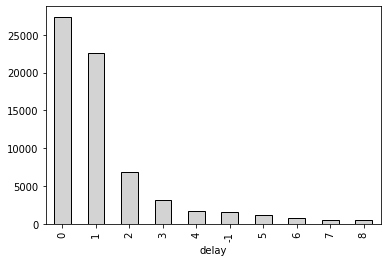

In [9]:
delays.groupby('delay').count()['weekday'].sort_values(ascending=False)[:10].plot.bar(color='lightgray', edgecolor='black')

Text(0.5, 1.0, "Each hours's average delay")

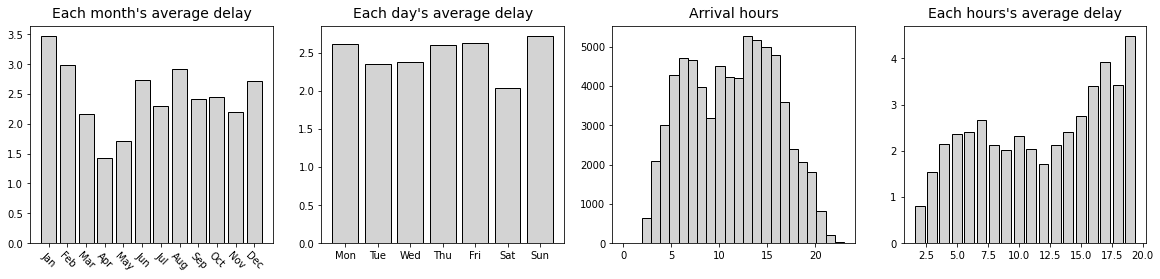

In [10]:
df_hour = df.copy()
df_hour['hour'] = df_hour['time'].apply(
    lambda x: x.hour
)
df_hour['month'] = df_hour['time'].apply(
    lambda x: x.month
)

plt.figure(figsize=(20,4))


plt.subplot(1, 4, 1)
weekday_avgdelay = df_hour.groupby('month').mean()['delay'].to_numpy()
plt.bar("Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split(" "),
        weekday_avgdelay,
        edgecolor="black",
        color="lightgray")
plt.xticks(rotation=-45)

plt.title("Each month's average delay", size=14, pad=8)



plt.subplot(1, 4, 2)
weekday_avgdelay = df.groupby('weekday').mean()['delay'].to_numpy()
plt.bar("Mon Tue Wed Thu Fri Sat Sun".split(" "),
        weekday_avgdelay,
        edgecolor="black",
        color="lightgray")

plt.title("Each day's average delay", size=14, pad=8)



plt.subplot(1, 4, 3)
plt.hist(df_hour['hour'],
         bins=24,
         edgecolor="black",
         color="lightgray")

plt.title('Arrival hours', size=14, pad=8)



plt.subplot(1, 4, 4)
time_avgdelay = df_hour.groupby('hour').mean()['delay'].to_numpy()
plt.bar(range(23)[2:-3],
        time_avgdelay[2:-3],
        edgecolor="black",
        color="lightgray")

plt.title("Each hours's average delay", size=14, pad=8)


In [11]:
print("Delay median\t\t", df['delay'].median())
print("Delay mean\t\t\t", round(df['delay'].mean(), 2))
print('---------')
print("Delay std\t\t\t", round(df['delay'].std(), 2))
print("Delay absolute dev\t", round(df['delay'].mad(), 2))
print('---------')
print("Unique trains:\t\t", len(df['code'].unique()))

Delay median		 1.0
Delay mean			 2.48
---------
Delay std			 9.01
Delay absolute dev	 3.14
---------
Unique trains:		 264


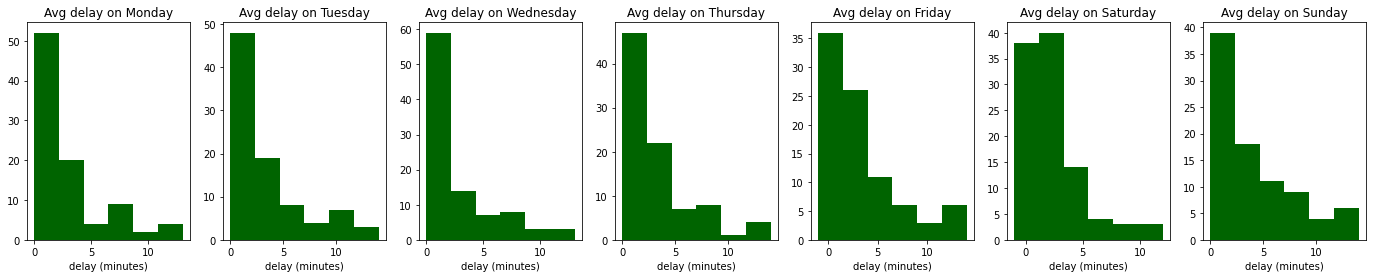

In [12]:
fig, axes = plt.subplots(1,7,figsize=(24,4))
weekdays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

for i in range(7):
    d = df[ (df['code'] == "IC12") & (df['weekday'] == i) & (df['delay'] < 15) ]["delay"].to_numpy()
    
    axes[i].hist(d, bins=6, color="darkgreen")
    axes[i].set_xlabel("delay (minutes)")
    axes[i].set_title(("Avg delay on " + weekdays[i]))

In [13]:
# most delayed trains

threshold = 5
delay_count = delays[['code', 'delay']]
delay_count['delay'] = delay_count['delay'].apply(lambda x: 0 if x<threshold else 1)
delay_count = delay_count.groupby('code').sum().set_axis(['delay_count'], axis=1)

most_delayed = delays.groupby('code').count()['weekday'].to_frame()

delay_stats = most_delayed.join(delay_count)
delay_stats['delay_pct'] = delay_stats.apply(
    lambda x: x['delay_count'] / x['weekday'],
    axis = 1
)
delay_stats.set_axis(['trips', 'delay_count', 'delay_pct'], axis=1, inplace=True)

delay_stats[ delay_stats['trips'] > 100 ].sort_values('delay_pct', ascending=False).head(5)

,trips,delay_count,delay_pct
code,,,
IC12,729,241,0.330590
IC10,724,231,0.319061
IC986,269,83,0.308550
IC968,423,129,0.304965
IC104,516,149,0.288760


## Processing data to into datapoints, features and labels


In [14]:
print(delays.dtypes)
print(weather.dtypes)

weekday      int64
code        object
code_int     int64
delay        int64
dtype: object
precip    float64
snow      float64
temp      float64
dtype: object


In [15]:
data = delays.join(weather)
data = data[['weekday', 'code', 'code_int', 'precip', 'snow', 'temp', 'delay']]

data.head()

,weekday,code,code_int,precip,snow,temp,delay
date,,,,,,,
2020-01-01 03:00:00,2,S35,0,0.0,0.0,0.7,0
2020-01-01 04:00:00,2,IC21,1,0.0,0.0,0.8,1
2020-01-01 05:00:00,2,IC1,2,0.0,0.0,1.2,1
2020-01-01 05:00:00,2,S155,3,0.0,0.0,1.2,0
2020-01-01 05:00:00,2,S41,4,0.0,0.0,1.2,3


In [16]:
# Adding month feature
data['month'] = pd.Series(data.index, index=data.index).map(
    lambda x: x.month
)
data = data[['month', 'weekday', 'code', 'code_int', 'precip', 'snow', 'temp', 'delay']].dropna()

In [18]:
 data[data['delay'] == 0].size / data.size

0.3884861224314701

In [23]:
# Prepares the features and labels of the selected route

def prepare(dframe) -> (np.ndarray, np.ndarray):

    dframe = dframe.dropna()

    X = dframe[['code_int', 'month', 'weekday', 'precip', 'snow', 'temp']].to_numpy().reshape(-1, 6)
    y = dframe['delay'].to_numpy()

    return X, y


def prepare_filter(route: str, dropna: bool = True) -> (np.ndarray, np.ndarray):
    filtered = data[ data['code'] == route.upper() ].dropna()
    if len(filtered) == 0:
        raise Exception(f"No data found for route {route}")

    X = filtered[['code_int', 'month', 'weekday', 'precip', 'snow', 'temp']].to_numpy().reshape(-1, 6)
    y = filtered['delay'].to_numpy()

    return X, y

In [24]:
X, y = prepare(data)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_res, y_train, y_res = train_test_split(X, y_classification, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_res, y_res, test_size=0.5)

print(X_train.size / X.size)
print(X_val.size / X.size)
print(X_test.size / X.size)

0.5999885604793159
0.20000571976034204
0.20000571976034204
